## Import libraries

In [416]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error 
import pickle

## Read the file

In [306]:
df_train = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
df_val = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet")

## Basic data exploration

In [307]:
df_train.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [308]:
df_train.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge'],
      dtype='object')

In [309]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               76518 non-null  int64         
 1   lpep_pickup_datetime   76518 non-null  datetime64[us]
 2   lpep_dropoff_datetime  76518 non-null  datetime64[us]
 3   store_and_fwd_flag     40471 non-null  object        
 4   RatecodeID             40471 non-null  float64       
 5   PULocationID           76518 non-null  int64         
 6   DOLocationID           76518 non-null  int64         
 7   passenger_count        40471 non-null  float64       
 8   trip_distance          76518 non-null  float64       
 9   fare_amount            76518 non-null  float64       
 10  extra                  76518 non-null  float64       
 11  mta_tax                76518 non-null  float64       
 12  tip_amount             76518 non-null  float64       
 13  t

In [310]:
## for data dictionary : https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf

In [311]:
## Filter dispatch
# df = df[df["trip_type"] == 2]
# Using Dispatch results in very few records where trip trip is greater than 1 minute and less than 60 minutes

## Feature Engineering - Duration

In [312]:
def data_preprocessing(df):
    ## Calculate the duration
    df["Duration"] = df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]
    ## Duration in minutes can be used as the target instead of all the contents
    ## Extract the minutes from the duration column
    # td = df["Duration"].iloc[0]
    # td.total_seconds()/60
    ## Create duration column in minutes
    df["Duration"] = df["Duration"].apply(lambda td : td.total_seconds()/60)
    df = df[(df["Duration"] >= 1) & (df["Duration"] <= 60)]
    return df

## Visualize Duration column

/var/folders/sw/tfz5f3017jg92rqtyhd5vrnh0000gn/T/ipykernel_12986/3707524882.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train["Duration"])


<Axes: xlabel='Duration', ylabel='Density'>

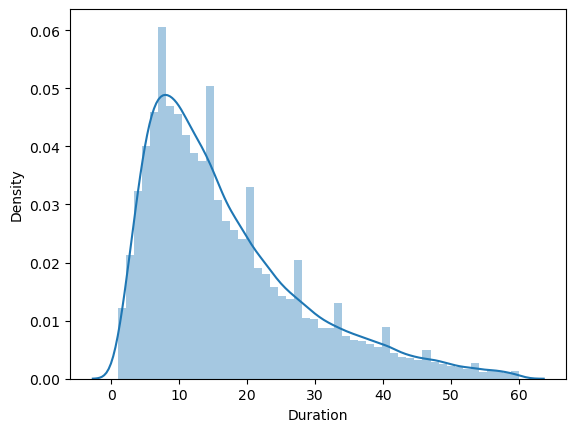

In [336]:
df_train = data_preprocessing(df_train)
df_val = data_preprocessing(df_val)
sns.distplot(df_train["Duration"])

## Explore the Duration column

In [323]:
## Observation
## A very long tail towards the right

In [324]:
df_train["Duration"].describe()

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
25%          8.050000
50%         14.000000
75%         22.633333
max         60.000000
Name: Duration, dtype: float64

In [325]:
df_train["Duration"].describe(percentiles = [0.95, 0.98, 0.99])

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
50%         14.000000
95%         41.000000
98%         48.781000
99%         53.000000
max         60.000000
Name: Duration, dtype: float64

## Feature Selection - numerical and categorical variables

In [326]:
## Feature Selection
categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

In [327]:
df_train[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

## One hot encoding of the categorical column

In [328]:
## One hot encoding of the categorical variables - Dictionary Vectoriser
## Dictionary Vectoriser categorises everything that is not a number

In [329]:
df_train[categorical] = df[categorical].astype(str)

In [330]:
## Use dictionary and convert every row as a key value pair
df_train[categorical + numerical].iloc[:10].to_dict(orient = 'records')

[{'PULocationID': '43', 'DOLocationID': '151', 'trip_distance': 1.01},
 {'PULocationID': '166', 'DOLocationID': '239', 'trip_distance': 2.53},
 {'PULocationID': '41', 'DOLocationID': '42', 'trip_distance': 1.12},
 {'PULocationID': '168', 'DOLocationID': '75', 'trip_distance': 1.99},
 {'PULocationID': '75', 'DOLocationID': '75', 'trip_distance': 0.45},
 {'PULocationID': '225', 'DOLocationID': '265', 'trip_distance': 12.19},
 {'PULocationID': '244', 'DOLocationID': '244', 'trip_distance': 3.39},
 {'PULocationID': '75', 'DOLocationID': '213', 'trip_distance': 6.69},
 {'PULocationID': '74', 'DOLocationID': '238', 'trip_distance': 2.34},
 {'PULocationID': '74', 'DOLocationID': '60', 'trip_distance': 5.48}]

In [331]:
# prepare the train_dict based 

In [332]:
train_dict = df_train[categorical + numerical].to_dict(orient = "records")

In [333]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)

In [334]:
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 221724 stored elements and shape (73908, 507)>

In [335]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',

## 1st pass : Linear Regression Model

In [337]:
target = "Duration"
y_train = df_train[target].values
y_val = df_val[target].values

In [338]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [339]:
y_pred = lr.predict(X_train)

/var/folders/sw/tfz5f3017jg92rqtyhd5vrnh0000gn/T/ipykernel_12986/3930761079.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label = "prediction")
/var/folders/sw/tfz5f3017jg92rqtyhd5vrnh0000gn/T/ipykernel_12986/3930761079.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, l

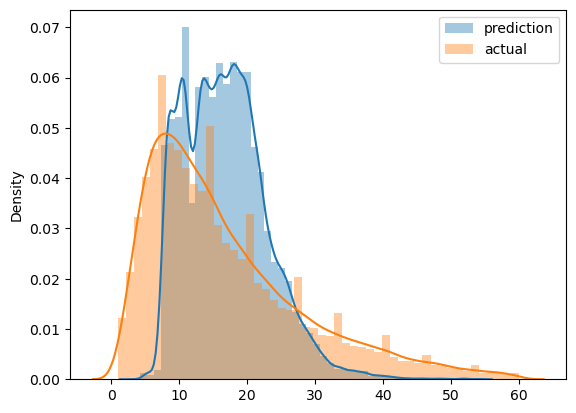

In [340]:
sns.distplot(y_pred, label = "prediction")
sns.distplot(y_train, label = "actual")
plt.legend()

In [341]:
mean_squared_error(y_train, y_pred)

96.57718032040486

In [342]:
## Observation
## Linear Regression Model performs poorly on the given dataset

## 2nd Iteration for Linear Regression - excluding categorical variables 

In [343]:
## If we don't specify our categorical features at all
categorical = []
numerical = ["trip_distance"]

In [344]:
train_dict = df_train[categorical + numerical].to_dict(orient = "records")

In [345]:
X_train = dv.fit_transform(train_dict)

In [346]:
lr.fit(X_train, y_train)

LinearRegression()

In [347]:
y_pred = lr.predict(X_train)

/var/folders/sw/tfz5f3017jg92rqtyhd5vrnh0000gn/T/ipykernel_12986/1111677883.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label = "predicted")
/var/folders/sw/tfz5f3017jg92rqtyhd5vrnh0000gn/T/ipykernel_12986/1111677883.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, la

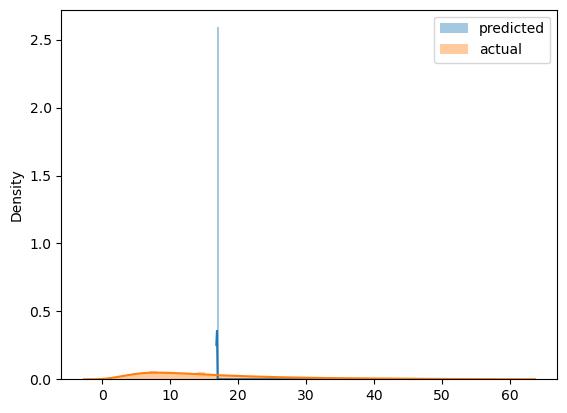

In [348]:
sns.distplot(y_pred, label = "predicted")
sns.distplot(y_train, label = "actual")
plt.legend()

In [349]:
mean_squared_error(y_pred, y_train)

133.68101072428487

In [350]:
## Observation
## No significant improvement in model

## 3rd iteration - Use Lasso Regression

In [351]:
categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

In [352]:
train_dict = df_train[numerical + categorical].to_dict(orient = "records")

In [353]:
X_train = dv.fit_transform(train_dict)

In [354]:
lr.fit(X_train, y_train)

LinearRegression()

In [355]:
y_pred = lr.predict(X_train)

/var/folders/sw/tfz5f3017jg92rqtyhd5vrnh0000gn/T/ipykernel_12986/1111677883.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label = "predicted")
/var/folders/sw/tfz5f3017jg92rqtyhd5vrnh0000gn/T/ipykernel_12986/1111677883.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, la

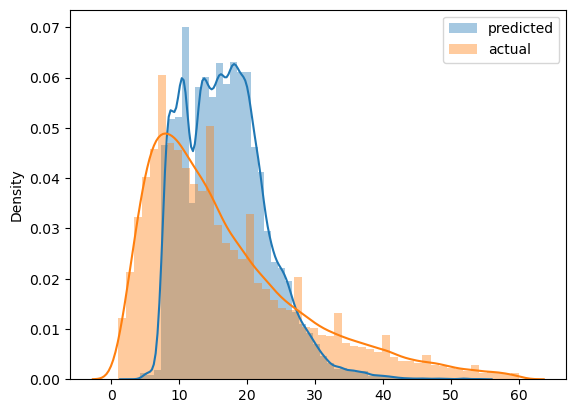

In [356]:
sns.distplot(y_pred, label = "predicted")
sns.distplot(y_train, label = "actual")
plt.legend()

In [357]:
mean_squared_error(y_pred, y_train)

96.57718032040486

In [358]:
len(df_train), len(df_val)

(73908, 61921)

## Scores on the validation set

In [385]:
val_dicts = df_val[categorical + numerical].to_dict(orient = "records")
X_val = dv.transform(val_dicts)

In [386]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred)

167.66641288014728

In [387]:
lr = Lasso(alpha = 100)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred)

149.15055213540228

In [388]:
lr = Ridge(alpha = 100)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred)

157.2376512261907

In [397]:
df_val["PULocationID"] = df_val["PULocationID"].astype(str)
df_val["DOLocationID"] = df_val["DOLocationID"].astype(str)

/var/folders/sw/tfz5f3017jg92rqtyhd5vrnh0000gn/T/ipykernel_12986/3090288550.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["PULocationID"] = df_val["PULocationID"].astype(str)
/var/folders/sw/tfz5f3017jg92rqtyhd5vrnh0000gn/T/ipykernel_12986/3090288550.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["DOLocationID"] = df_val["DOLocationID"].astype(str)


In [398]:
## Create new set of features
df_train["PU_DO"] = df_train["PULocationID"] + "_" + df_train["DOLocationID"]
df_val["PU_DO"] = df_val["PULocationID"] + "_" + df_val["DOLocationID"]

/var/folders/sw/tfz5f3017jg92rqtyhd5vrnh0000gn/T/ipykernel_12986/1218009576.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["PU_DO"] = df_val["PULocationID"] + "_" + df_val["DOLocationID"]


In [399]:
categorical = ["PU_DO"]
numerical = ["trip_distance"]

In [403]:
val_dict = df_val[categorical + numerical].to_dict(orient = "records")

In [404]:
X_val = dv.fit_transform(train_dict)

In [405]:
lr = LinearRegression()
lr.fit(X_val, y_val)
y_pred = lr.predict(X_val)

In [407]:
mean_squared_error(y_pred, y_val)

27.89374107816359

In [414]:
lr = Lasso(alpha = 0.0001)
lr.fit(X_val, y_val)
y_pred = lr.predict(X_val)

In [415]:
mean_squared_error(y_pred, y_val)

30.474541712342916

In [417]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr),f_out)

FileNotFoundError: [Errno 2] No such file or directory: 'models/lin_reg.bin'